In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-image-with-lanes/test_image.jpg
/kaggle/input/video-file-for-lane-detection-project/test_video.mp4


In [2]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
%matplotlib inline

### We will first show the image in colour using OpenCV

<function matplotlib.pyplot.show(close=None, block=None)>

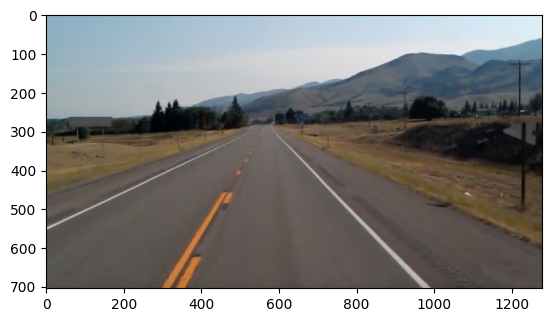

In [3]:
image = cv2.cvtColor(cv2.imread("../input/road-image-with-lanes/test_image.jpg"), cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show

In [4]:
import numpy as np

lane_image = np.copy(image)
lane_image.shape

(704, 1279, 3)

## **NOW we change it to GRAYSCALE Image**

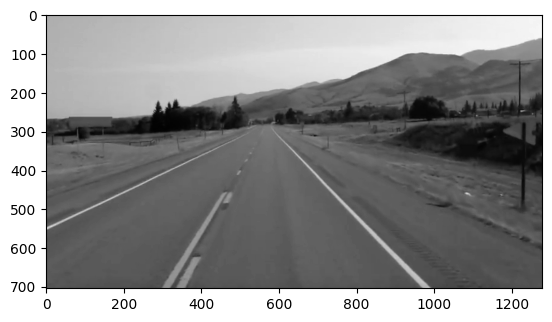

In [5]:
gray_img = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.show()

## **NOW we will apply a Gaussian Blur**

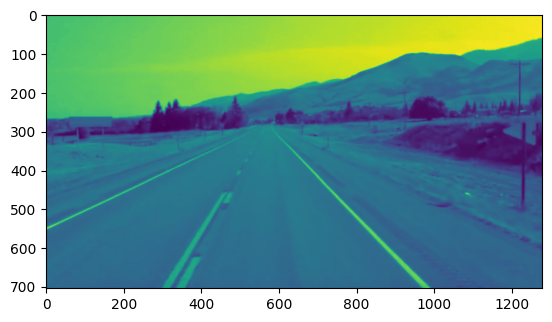

In [6]:
blurred_img = cv2.GaussianBlur(gray_img, (5,5), 0)

plt.imshow(blurred_img)
plt.show()

## **NOW we will apply Canny to show the edges**

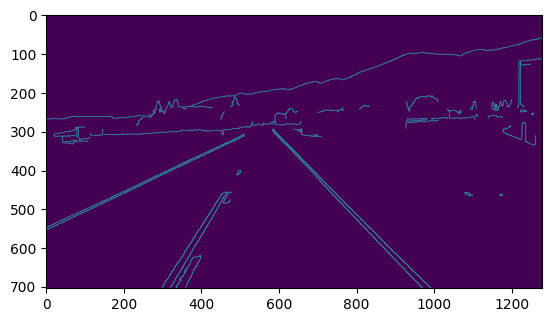

In [7]:
canny_img = cv2.Canny(blurred_img, 50, 150)

plt.imshow(canny_img)
plt.show()

## **INSTEAD** of applying all these filters one by one, lets group them together**
## We will make a function, and put all of the filters in it so at the end all we need to do is specify the function for it to work

In [8]:
def Canny(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
   # plt.imshow(gray_img, cmap='gray')
    #plt.show()
    blur_img = cv2.GaussianBlur(gray_img, (5,5), 0)
    #plt.imshow(blur_img)
    #plt.show()
    canny_img = cv2.Canny(blur_img, 50, 150)
    #plt.imshow(canny_img)
   # plt.show()

    return canny_img


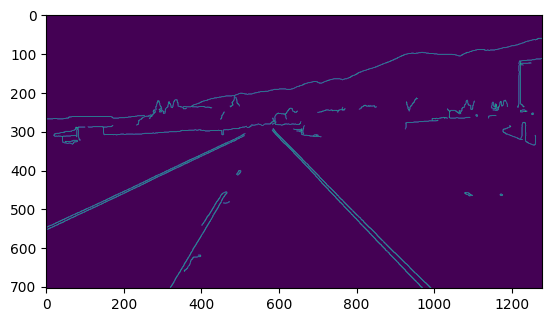

In [9]:
image = cv2.imread('/kaggle/input/road-image-with-lanes/test_image.jpg')
lane_image = np.copy(image)
canny = Canny(lane_image)

plt.imshow(canny)

# **NOW** we will make a function that will find the region of interest 
## after that we will apply bitwise AND operator to make sure only that region of interest is selected

In [10]:
def region_of_interest(image):
    height = 700
    polygons = np.array([[(250,height), (1000,height), (600,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_region = cv2.bitwise_and(image, mask)
    
    return masked_region

In [11]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_image

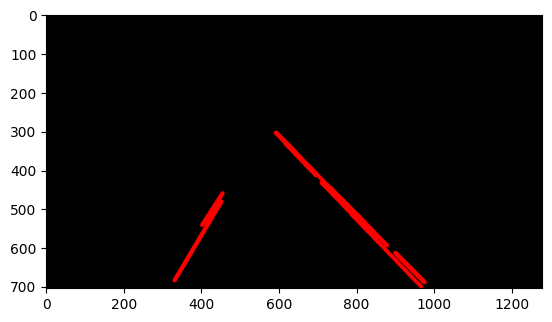

In [12]:
image = cv2.imread('/kaggle/input/road-image-with-lanes/test_image.jpg')

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
line_image = display_lines(lane_image, lines)

plt.imshow(line_image)
plt.show()